In [2]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
import shutil
import collections
import math
from torch.utils.data import DataLoader
import pandas as pd

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
def load_labels(data_dir):
  with open(os.path.join(data_dir, 'labels.csv'), 'r') as f:
    lines = f.readlines()[1:]
  
  tokens = [l.rstrip().split(',') for l in lines]
  return dict((name, label) for name, label in tokens)

loss = nn.CrossEntropyLoss(reduction='none')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_dir = './data'
batch_size = 128
valid_ratio = 0.1
labels = load_labels(data_dir)

def get_model():
  net = nn.Sequential()
  net.features = torchvision.models.resnet34(pretrained=True)
  net.output_new = nn.Sequential(nn.Linear(1000, 256), nn.ReLU(), nn.Linear(256, 120))

  net.to(device)
  for param in net.features.parameters():
    param.requires_grad = False
  return net

In [4]:
def copyfile(filename, target_dir):
    """Copy a file into a target directory."""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def sort_train_validation_data(data_dir, labels, valid_ratio = 0.1):
  n = collections.Counter(labels.values()).most_common()[-1][1]
  n_valid_per_label = max(1, math.floor(n * valid_ratio))
  label_count = {}
  for train_img in os.listdir(os.path.join(data_dir, 'train')):
    label = labels[train_img.split('.')[0]]
    f = os.path.join(data_dir, 'train', train_img)
    copyfile(f, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))

    if label not in label_count or label_count[label] < n_valid_per_label:
      copyfile(f, os.path.join(data_dir, 'train_valid_test', 'train', label))
    else:
      copyfile(f, os.path.join(data_dir, 'train_valid_test', 'valid', label))

    if label not in label_count:
      label_count[label] = 0
    label_count[label] += 1

def sort_test_data(data_dir):
  for test_img in os.listdir(os.path.join(data_dir, 'test')):
    copyfile(os.path.join(data_dir, 'test', test_img), os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

In [22]:
sort_train_validation_data(data_dir, labels, valid_ratio)
sort_test_data(data_dir)

In [4]:
def train(net, train_dataloader, valid_dataloader, num_epochs, lr, weight_decay, lr_period, lr_decay):
  trainer = torch.optim.Adam(net.parameters(), lr, weight_decay=weight_decay)
  scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
  
  net.to(device)
  legend = ['train_loss', 'train_acc']
  if valid_dataloader is not None:
    legend.append('valid_acc')

  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 3], legend=legend)
  for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    valid_acc = 0
    num_train_examples = 0
    num_valid_examples = 0

    for i, (X, Y) in enumerate(train_dataloader):
      X, Y = X.to(device), Y.to(device)
      # Set to train mode
      net.train()
      # Zero out gradients
      trainer.zero_grad()
      # Backward prop
      Y_hat = net(X)
      l = loss(Y_hat, Y)
      l.sum().backward()

      # Update trainer and lr_scheduler
      trainer.step()

      # Update stats
      num_train_examples += X.shape[0]
      train_loss += l.sum().detach().cpu().numpy()
      train_acc += d2l.accuracy(Y_hat, Y)
      animator.add(epoch + 1 + i / len(train_dataloader), (train_loss / num_train_examples, train_acc / num_train_examples, None))


    if valid_dataloader is not None:
      for i, (X, Y) in enumerate(valid_dataloader):
        X, Y = X.to(device), Y.to(device)
        net.eval()
        num_valid_examples += X.shape[0]
        Y_hat = net(X.to(device))
        valid_acc += d2l.accuracy(Y_hat, Y)
      animator.add(epoch + 1 + i / len(valid_dataloader), (None, None, valid_acc / len(valid_dataloader)))

    scheduler.step()
  

In [5]:
train_transform = torchvision.transforms.Compose([
  torchvision.transforms.RandomResizedCrop(224, scale=(0.5, 1), ratio=(1/2, 2)),
  torchvision.transforms.RandomHorizontalFlip(),
  torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
])
test_transform = torchvision.transforms.Compose([
  torchvision.transforms.Resize((224, 224)),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
])
train_data, train_valid_data = [torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder), transform=train_transform) for folder in ['train', 'train_valid']]
valid_data, test_data = [torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder), transform=test_transform) for folder in ['valid', 'test']]

In [6]:
batch_size = 128
train_dataloader, train_valid_dataloader = [DataLoader(data, batch_size=batch_size, shuffle=True) for data in [train_data, train_valid_data]]
valid_dataloader, test_dataloader = [DataLoader(data, batch_size=batch_size, shuffle=False) for data in [valid_data, test_data]]

In [7]:
# Hyperparams
lr = 2e-4
num_epochs=25
weight_decay=5e-4
lr_period=4
lr_decay=0.9

/home/darren/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/darren/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


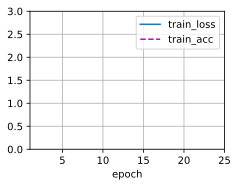

In [8]:
# Training with full train
net = get_model()
train(net, train_valid_dataloader, None, num_epochs=num_epochs, lr=lr, weight_decay=weight_decay, lr_period=lr_period, lr_decay=lr_decay)

In [67]:
# Evaluation
predictions = []
def eval_test():
  for X, _ in test_dataloader:
    net.eval()
    Y_hat = net(X.to(device))
    probabilities = nn.functional.softmax(Y_hat, dim=1)
    predictions.extend([p for p in probabilities.detach().cpu().tolist()])

eval_test()

In [1]:
ids = list(map(lambda f: f.split('.')[0], sorted(os.listdir(os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))))
cols = ['id'] + [breed for breed in train_valid_data.classes]
df = pd.DataFrame([[imgId] + pred for imgId, pred in zip(ids, predictions)], columns=cols)
df.to_csv('submission.csv', index=False)

NameError: name 'os' is not defined